# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import cv2
import itertools
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sklearn.model_selection
import tensorflow as tf


In [2]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data
training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# Number of training examples
n_train = len(y_train)

# Number of testing examples
n_test = len(y_test)

# What's the shape of an image?
image_shape = X_train[0].shape

# How many classes are in the dataset
n_classes = len(set(y_train))

# The unique classes in the training set
classes = set(y_train)
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
# Display one of each kind of image
def display_unique_classes(X, y,cmap=None):
    labels = set(y)
    for label in labels:
        idx = np.nonzero((y) == label)[0][0]
        image = X[idx,:,:]
        if cmap:
            plt.imshow(image,cmap)
        else:
            plt.imshow(image)
        plt.show()
        
#display_unique_classes(X_train, y_train)

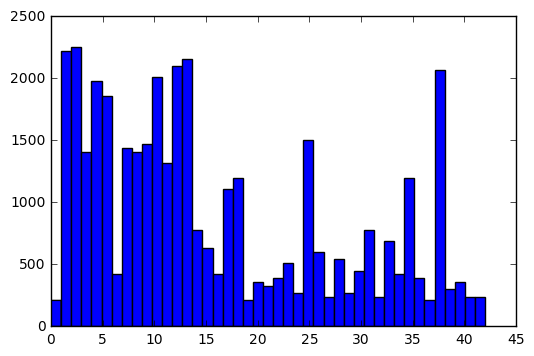

In [5]:
# As it can be seen, there are not an equal number of examples in all classes
plt.hist(y_train,bins=43);

In [6]:
# Compute the max and min observations for any class
# We can see that some classes have as many as 2 thousand examples,
# while another class has as few as 200 examples

dist = np.histogram(y_train, bins=range(44))
classes = dist[1]
counts = dist[0]
max_count = max(counts)
min_count = min(counts)

print("Max observations for a class:", max_count)
print("Min observations for a class:", min_count)

Max observations for a class: 2250
Min observations for a class: 210


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
def convert_image_to_gray(data):
    # Convert image to grayscale
    return np.mean(data, axis=3)
    
def preprocess_data(data):
     
    # Mean Subtraction to center the data at the origin
    data -= np.mean(data)
    
    # Normalization
    data /= np.std(data, axis = 0)
    
    # PCA and whitening?
    return data

def reshape_data(data):
    # Convert entire image to a single row?
    return data.reshape(-1, image_shape[0], image_shape[1])

In [8]:
# One hot encode labels
def encode_labels(labels):
    labels = (np.arange(n_classes) == labels[:,None]).astype(np.float)
    return labels

In [9]:
X_train_processed = preprocess_data(convert_image_to_gray(X_train))
X_test_processed = preprocess_data(convert_image_to_gray(X_test))

In [10]:
y_test_one_hot = encode_labels(y_test)

In [11]:
#display_unique_classes(X_train_processed, y_train, cmap='gray')

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
- **Converting the image to grayscale**: This is done for simplicity and the fact that color alone should not cause the classifier to be biased
- **One hot encoding the labels**: This is done to make computing the cross entropy for the loss function possible
- **Mean Subtraction**: This centers the cloud of data around the origin in every dimension.
- **Normalization**: Normalize the data dimensions so that they are of the same scale. The way I have done this is by dividing each dimension by its standard deviation once it has been zero-centered. This is not strictly needed for images because the relative scales of pixels are already approximately equal
- **Image reshaping** - convolutions need the image data formatted as a cube (width by height by #channels)

Possible further preprocessing could include:
1. PCA
2. Whitening

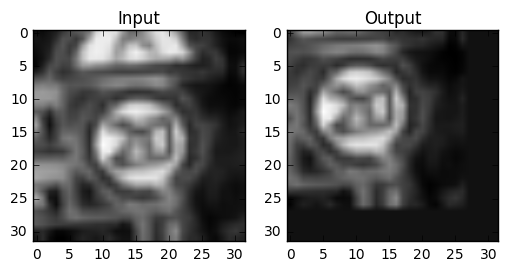

In [12]:
### Generate additional data for classes that have a small number of examples

def translate_image(image, tx, ty):
    """
        This function will result in a translated image
        Translation = shifting of the object's location
        
        image: the image to be translated
        tx: shift in the x direction
        ty: shift in the y direction
    """
    # Define the transformation matrix
    M = np.float32([[1, 0, tx],[0, 1, ty]])
    rows,cols = image.shape
    
    return cv2.warpAffine(image, M, (cols,rows))
    

plt.subplot(121),plt.imshow(X_train_processed[0], cmap='gray'),plt.title('Input');
translated_image = translate_image(X_train_processed[0], -5, -5)
plt.subplot(122),plt.imshow(translated_image, cmap='gray'),plt.title('Output');

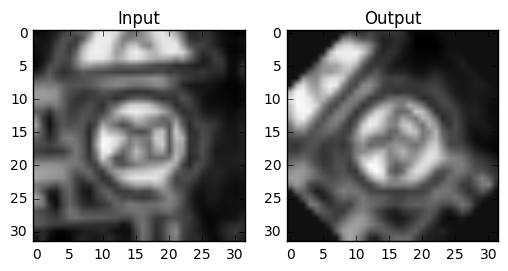

In [13]:
def rotate_image(image, angle):
    """
        This function rotates the given image through the given angle
        
        image: image to be rotated
        angle: angle through which the image is to be rotated
    """
    rows,cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    
    return cv2.warpAffine(image, M, (cols,rows))

plt.subplot(121),plt.imshow(X_train_processed[0], cmap='gray'),plt.title('Input');
rotated_image = rotate_image(X_train_processed[0], 45);
plt.subplot(122),plt.imshow(rotated_image, cmap='gray'),plt.title('Output');

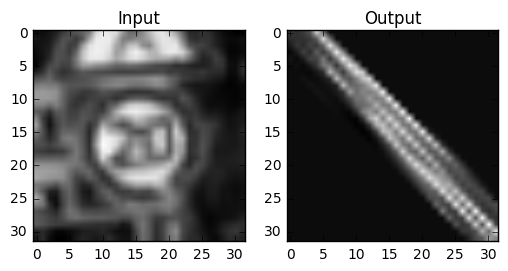

In [14]:
## Not sure if we want to use this as we get random images

def get_random_point(x_range, y_range):
    prop = 0.6
    x = random.randint(x_range - int(x_range * prop), x_range - int(x_range * (1-prop)))
    y = random.randint(y_range - int(y_range * prop), y_range - int(y_range * (1-prop)))
    return [x, y]

def get_n_random_points(n, x_range, y_range):
    return np.float32([get_random_point(x_range, y_range) for _ in range(n)])
    
def get_affine_transform(image):
    """
        In an affine transformation, 
        all parallel lines in the original image will
        stay parallel in the output image.
        
        We select three random points in the input image.
        And determine their position(randomly) in the output image
    """
    rows,cols = image.shape
    pts1 = get_n_random_points(3, rows, cols)
    pts2 = get_n_random_points(3, rows, cols)
    M = cv2.getAffineTransform(pts1, pts2)
    return cv2.warpAffine(image, M, (cols,rows))
    

plt.subplot(121),plt.imshow(X_train_processed[0], cmap='gray'),plt.title('Input');
affine_transformed_image = get_affine_transform(X_train_processed[0]);
plt.subplot(122),plt.imshow(affine_transformed_image, cmap='gray'),plt.title('Output');

In [15]:
def generate_training_data_map(X, y):
    """
        Given the two arrays X(array of input vectors) and Y(array of corresponding labels),
        generates a dictionary of the form:
        {
            label: [list of input vectors]
        }
        
    """
    training_data = {}
    classes = set(y)
    
    # Initialize the lists for each label
    for label in classes:
        training_data.setdefault(label, [])
        
    # Append to the list for each label
    for i,label in enumerate(y):
        training_data[label].append(X[i])
    
    return training_data

In [16]:
def generate_rotated_images(image, number_of_rotations):
    """
        image: seed image to generate more data
        number_of_rotations: number of images to be generated by rotating the seed image
    """
    degrees = 360
    degree_rotation_per_image = math.ceil(degrees/number_of_rotations)
    
    return [rotate_image(image, angle) for angle in range(0, 360, degree_rotation_per_image)]

In [17]:
def generate_translated_images(image, number_of_translations):
    """
        image: seed image to generate more data
        number_of_rotations: number of images to be generated by rotating the seed image
    """
    limit = 5
    pairs = list(itertools.combinations(range(-limit, limit), 2))[:number_of_translations]
    return [translate_image(image, pair[0], pair[1]) for pair in pairs]
        

In [18]:
def generate_additional_data(training_data_map):
    """
        For each label, this method calculates the number of examples that need to 
        be generated approximately and generates them by calling in some proportion
        the rotation and translation functions
    """
    proportion_rotation = 0.9
    # number of examples from each category to use to generate new data
    generator_size = 10

    for label in training_data_map:
        num_examples = len(training_data_map[label])
        num_to_generate = max_count - num_examples
        
        if num_to_generate > 0:
            # number of rotated images needed
            num_rotation = int(num_to_generate * proportion_rotation)
            # number of translated images needed
            num_translation = int(num_to_generate * (1 - proportion_rotation))
            
            
            num_rotation_per_example = math.ceil(num_rotation/generator_size)
            num_translation_per_example = math.ceil(num_translation/generator_size)
            
            # Iterate over the first ten examples in each category
            for i in range(generator_size):
                rotated_images = generate_rotated_images(training_data_map[label][i], num_rotation_per_example)
                training_data_map[label].extend(preprocess_data(rotated_images))
            
                translated_images = generate_translated_images(training_data_map[label][i], num_translation_per_example)
                training_data_map[label].extend(preprocess_data(translated_images))

In [19]:
def reformat_for_convolution(data, num_channels, image_shape):
    """
        Convolutions require the image formatted like a cube (with X height X num of channels)
    """
    return data.reshape(-1, image_shape[0], image_shape[1], num_channels).astype(np.float32)

In [20]:
def rebuild_training_data_from_map(training_data_map):
    X_train = []
    y_train = []
    
    for label in training_data_map:
        X_train.extend(training_data_map[label])
        y_train.extend([label] * len(training_data_map[label]))
    return X_train, np.array(y_train)

In [21]:
num_channels = 1

# convert into an easy way to generate additional data
# training_data_map = generate_training_data_map(X_train_processed, y_train)

# # generate additional data
# generate_additional_data(training_data_map)

# # Convert back to the form X,y
# X_train_new, y_train_new = rebuild_training_data_from_map(training_data_map)

# # One hot encode the training labels
# y_train_new_one_hot = encode_labels(y_train_new)

# #  Convert to an nd_array
# X_train_new = np.ndarray(shape=(len(X_train_new), image_shape[0], image_shape[1]), buffer=np.array(X_train_new))

# Reformat the data to make it convolution-friendly
X_train_new = reformat_for_convolution(X_train_processed, num_channels, image_shape)
y_train_one_hot = encode_labels(y_train)

X_test_processed = reformat_for_convolution(X_test_processed, num_channels, image_shape)

In [22]:
# Rename variable for consistency
X_train = X_train_new
y_train = y_train
y_train_one_hot = y_train_one_hot

X_test = X_test_processed
y_test = y_test
y_test_one_hot = y_test_one_hot

In [23]:
# Training data
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(type(y_train_one_hot), y_train_one_hot.shape)

# Testing data
print(type(X_test), X_test.shape)
print(type(y_test), y_test.shape)
print(type(y_test_one_hot), y_test_one_hot.shape)

<class 'numpy.ndarray'> (39209, 32, 32, 1)
<class 'numpy.ndarray'> (39209,)
<class 'numpy.ndarray'> (39209, 43)
<class 'numpy.ndarray'> (12630, 32, 32, 1)
<class 'numpy.ndarray'> (12630,)
<class 'numpy.ndarray'> (12630, 43)


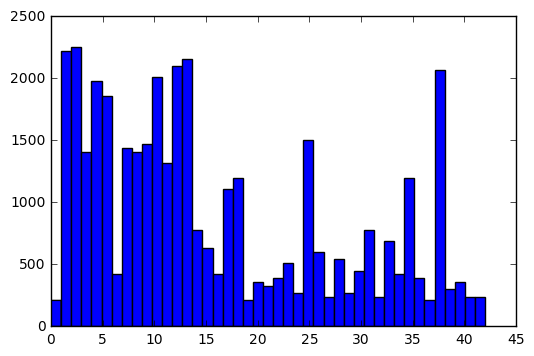

In [24]:
# All the classes now have roughly the same number of examples
plt.hist(y_train, bins=43);

42


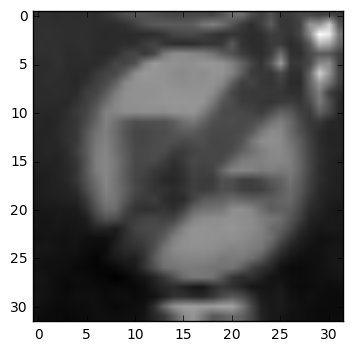

In [25]:
## Make sure that the labels are correct. Picking a random image to verify
i = 39208
plt.imshow(X_train[i].reshape(32,32), cmap="gray");
print(y_train[i]);

In [26]:
### split the data into training/validation/testing sets here.

In [27]:
# proportion of the training data to be used for training
proportion_train = 0.7

count_train = int(len(X_train) * 0.7)

# temp_X = X_train
# temp_y = y_train
# temp_y_hot = y_train_one_hot

# X_train = temp_X[:count_train]
# y_train = temp_y[:count_train]
# y_train_one_hot = temp_y_hot[:count_train]

# X_valid = temp_X[count_train:]
# y_valid = temp_y[count_train:]
# y_valid_one_hot = temp_y_hot[count_train:]
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.33, random_state=42)
y_train_one_hot = encode_labels(y_train)
y_valid_one_hot = encode_labels(y_valid)

39209
39209
39209


17

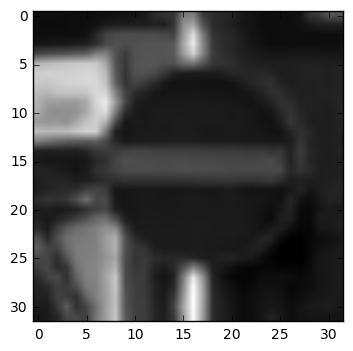

In [28]:
# Ensure all sizes add up
print(len(X_train) + len(X_valid))
print(len(y_train) + len(y_valid))
print(len(y_train_one_hot) + len(y_valid_one_hot))

plt.imshow(X_valid[800].reshape(32, 32), cmap='gray');
y_valid[800]

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

##### Training, Validation and Testing data sets
- A test data set is already provided
- For the purpose of hyperparameter tuning, the training data set is split into two parts - one for training and one for validation.
- This split is doing using a simple division of the data using a proportion.

##### Generating additional data
- As can be seen from the histogram and the min and the max computed below that, some classes have as many as 2000 examples while another class has as few as 200 examples.
- This will cause the classifier to be biased towards the classes that have a larger number of examples
- To prevent this, we generate additional test data for classes which have a smaller number of examples
- There are three ways in which I am generating additional data:
1. Translations: Shifting the image in the x and y directions
2. Rotation of the image through various angles
3. Affine transformations of the image

In [29]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [30]:
X_train = X_train.reshape(-1, image_shape[0] * image_shape[1]).astype(np.float64)
X_valid = X_valid.reshape(-1, image_shape[0] * image_shape[1]).astype(np.float64)
X_test = X_test.reshape(-1, image_shape[0] * image_shape[1]).astype(np.float64)

print(X_train.shape, type(X_train[0][0]))
print(X_valid.shape)
print(X_test.shape)

(26270, 1024) <class 'numpy.float64'>
(12939, 1024)
(12630, 1024)


In [31]:
# y_train_subset.shape

In [40]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 1000
hidden_layer_1_size = 1024
hidden_layer_2_size = 728
beta = 0.003
num_steps = 5000
keep_prob = 0.8

graph = tf.Graph()
with graph.as_default():    
  tf_train_dataset = tf.placeholder(tf.float64, shape=[None, image_shape[0] * image_shape[1]])
  tf_train_labels = tf.placeholder(tf.float64, shape=[None, n_classes])
  tf_valid_dataset = tf.constant(X_valid)
  tf_test_dataset = tf.constant(X_test)
  
  weights1 = tf.Variable(tf.truncated_normal([image_shape[0] * image_shape[1], hidden_layer_1_size], dtype=tf.float64), dtype=tf.float64)
  biases1 = tf.Variable(tf.zeros([hidden_layer_1_size], dtype=tf.float64), dtype=tf.float64)
  weights2 = tf.Variable(tf.truncated_normal([hidden_layer_1_size, hidden_layer_2_size], dtype=tf.float64), dtype=tf.float64)
  biases2 = tf.Variable(tf.zeros([hidden_layer_2_size], dtype=tf.float64), dtype=tf.float64) 
  weights3 = tf.Variable(tf.truncated_normal([hidden_layer_2_size, n_classes], dtype=tf.float64), dtype=tf.float64)
  biases3 = tf.Variable(tf.zeros([n_classes], dtype=tf.float64), dtype=tf.float64)

  def model(data):
    hidden_layer_1_output = tf.matmul(data, weights1) + biases1 
    hidden_layer_1_output = tf.nn.relu(hidden_layer_1_output)
    tf.nn.dropout(hidden_layer_1_output, keep_prob)  
    
    hidden_layer_2_output = tf.matmul(hidden_layer_1_output, weights2) + biases2
    hidden_layer_2_output = tf.nn.relu(hidden_layer_2_output)
    tf.nn.dropout(hidden_layer_2_output, keep_prob)
    
    output = tf.matmul(hidden_layer_2_output, weights3) + biases3
    return output
  
#   batch = tf.Variable(0)
#   # Decay once per epoch, using an exponential schedule starting at 0.01.
#   learning_rate = tf.train.exponential_decay(
#       0.09,                # Base learning rate.
#       batch * train_subset,  # Current index into the dataset.
#       X_train.shape[0],          # Decay step.
#       0.95,                # Decay rate.
#       staircase=True)
#   
  output = model(tf_train_dataset)
  cross_entropy = (-tf.reduce_sum(tf_train_labels * tf.log(tf.clip_by_value(tf.nn.softmax(output),1e-10,1.0))))/train_subset
  loss = tf.reduce_mean(cross_entropy)
  loss += beta * tf.nn.l2_loss(weights1) + beta * tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)#, global_step=batch)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(output)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  init = tf.initialize_all_variables()

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  session.run(init)
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    X_train_subset, _, y_train_subset, _ = sklearn.model_selection.train_test_split(X_train, y_train, train_size=1000)
    y_train_subset_one_hot = encode_labels(y_train_subset)
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict={tf_train_dataset: X_train_subset, tf_train_labels: y_train_subset_one_hot})
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, y_train_subset_one_hot))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), y_valid_one_hot))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), y_test_one_hot))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Loss at step 0: 14149.933608
Training accuracy: 2.7%
Validation accuracy: 3.3%
Loss at step 100: 1979.365509
Training accuracy: 6.3%
Validation accuracy: 5.5%
Loss at step 200: 1866.642003
Training accuracy: 0.6%
Validation accuracy: 0.7%
Loss at step 300: 1758.612527
Training accuracy: 3.4%
Validation accuracy: 3.4%
Loss at step 400: 1656.909794
Training accuracy: 5.9%
Validation accuracy: 5.3%
Loss at step 500: 1562.847251
Training accuracy: 0.8%
Validation accuracy: 1.1%
Loss at step 600: 1472.034222
Training accuracy: 5.6%
Validation accuracy: 5.5%
Loss at step 700: 1387.499388
Training accuracy: 5.9%
Validation accuracy: 5.5%
Loss at step 800: 1308.797287
Training accuracy: 2.2%
Validation accuracy: 2.1%
Loss at step 900: 1233.202783
Training accuracy: 5.3%
Validation accuracy: 5.8%
Loss at step 1000: 1162.486310
Training accuracy: 5.9%
Validation accuracy: 5.8%
Loss at step 1100: 1096.157061
Tra

In [33]:
# 27.3%
# 39 %
# 44.6 %
# 42.9 %
# 34.3 %
# 29.4 %
# 32.4 %
# 39.2 

# 47.5%!! 
# 54.7!!
# 56.7!!
# 56.8%!! beta=0.008

# Went down to 51.9 with beta=0.006

# 64.6% with beta = 0.005



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [34]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [35]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [36]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.